In [1]:
import os
from pathlib import Path
import torch
import wandb
from torch import nn
import sys
from torchinfo import summary
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data import ConcatDataset
from torchvision import datasets
from torchvision.transforms import transforms
from torchvision.transforms import v2
import time 
import random
import numpy as np
import matplotlib.pyplot as plt
print("Libraries imported.")

Libraries imported.


In [2]:
# 랜덤 시드 고정
SEED = 1982
g = torch.Generator().manual_seed(SEED)  # 시드 지정된 Generator 생성

# Python, Numpy, PyTorch (CPU)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# PyTorch (GPU)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)  # 멀티 GPU 대비

# CuDNN (GPU 내부 연산 결정론적 모드 설정)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Random SEED {SEED} fixed.")

Random SEED 1982 fixed.


In [3]:
# 현재 노트북 파일의 위치를 기준으로 BASE_PATH 설정
BASE_PATH = str(Path.cwd().parent)  
print(f"BASE_PATH: {BASE_PATH}")

# BASE_PATH를 시스템 경로에 추가
sys.path.append(BASE_PATH)

# 공통 유틸리티 임포트
from _01_code._99_common_utils.utils import get_num_cpu_cores, is_linux, is_windows

print("Path configured and utilities imported.")

BASE_PATH: /home/work/link_dl/Deeplearning/git/link_dl
Path configured and utilities imported.


In [4]:
def get_fashion_mnist_data(batch_size,generator):
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    # 데이터를 텐서로 불러오기
    f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
    
    # 학습용 / 검증용 분리
    f_mnist_train, f_mnist_validation = random_split(
        f_mnist_train, [55_000, 5_000], generator=generator
    )

    # ==========================================================
    # Fashion MNIST의 Mean, Std 계산
    # ==========================================================
    print("Calculating mean and std for Fashion MNIST...")
    all_train_images = torch.stack([img for img, _ in f_mnist_train], dim=0)
    
    mean = all_train_images.view(-1).mean().item()
    std = all_train_images.view(-1).std().item()
    
    print(f"*** Calculated Mean: {mean} ***")
    print(f"*** Calculated Std: {std} ***")
    
    # 데이터 로더 생성
    print(f"Total Train Samples: {len(f_mnist_train)}") # 55,000개
    print(f"Num Validation Samples: {len(f_mnist_validation)}")

    num_data_loading_workers = get_num_cpu_cores()
    print("Number of Data Loading Workers:", num_data_loading_workers)

    train_data_loader = DataLoader(
        dataset=f_mnist_train, #원본 55,000개 데이터셋 사용
        batch_size=batch_size, shuffle=True,
        pin_memory=True, num_workers=num_data_loading_workers,
        generator=generator
    )

    validation_data_loader = DataLoader(
        dataset=f_mnist_validation, # 검증은 원본 5,000개
        batch_size=batch_size, shuffle=False,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    # ==========================================================
    # 학습용 / 검증용 변환 파이프라인 분리
    # ==========================================================
    
    # [학습용] 증강(Augmentation) + 정규화(Normalize)
    f_mnist_train_transforms = v2.Compose([
        # --- Augmentation ---
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomAffine(degrees=10, translate=(0.05, 0.05)),
        
        # --- Common ---
        v2.ConvertImageDtype(torch.float), 
        v2.Normalize(mean=(mean,), std=(std,)) 
    ])
    
    # [검증용] 정규화(Normalize)만 적용
    f_mnist_validation_transforms = v2.Compose([
        v2.ConvertImageDtype(torch.float), 
        v2.Normalize(mean=(mean,), std=(std,)) 
    ])
    
    # 2개의 변환 파이프라인을 반환
    return train_data_loader, validation_data_loader, f_mnist_train_transforms, f_mnist_validation_transforms, mean, std

print("Function 'get_fashion_mnist_data' defined.")

Function 'get_fashion_mnist_data' defined.


In [5]:
def get_fashion_mnist_test_data(mean, std):
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    f_mnist_test_images = datasets.FashionMNIST(data_path, train=False, download=True)
    f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

    print("Num Test Samples: ", len(f_mnist_test))
    print("Sample Shape: ", f_mnist_test[0][0].shape)

    test_data_loader = DataLoader(dataset=f_mnist_test, batch_size=len(f_mnist_test))

    # ==========================================================
    # 변환 파이프라인 (테스트용)
    # 테스트 데이터에는 Augmentation을 적용하지 않고, 정규화만 수행
    # ==========================================================
    f_mnist_transforms = v2.Compose([
        v2.ConvertImageDtype(torch.float),
        v2.Normalize(mean=(mean,), std=(std,)) # 정규화 
    ])
    # ==========================================================

    return f_mnist_test_images, test_data_loader, f_mnist_transforms

print("Function 'get_fashion_mnist_test_data' defined.")

Function 'get_fashion_mnist_test_data' defined.


In [6]:
# config 딕셔너리 정의 (wandb.init() 호출 제거!)
data_config = {'batch_size': 1024}

# 학습 데이터 로드 (및 Mean/Std 계산)
# wandb.config.batch_size 대신 data_config['batch_size'] 사용
train_data_loader, validation_data_loader, train_transforms, val_transforms, mean, std = get_fashion_mnist_data(
    batch_size=data_config['batch_size'],
    generator=g
)
print()

# 테스트 데이터 로드 (계산된 Mean/Std 전달)
f_mnist_test_images, test_data_loader, test_transforms = get_fashion_mnist_test_data(mean, std)

print("\n--- All data loaded and ready ---")
print(f"Calculated Mean: {mean}")
print(f"Calculated Std: {std}")

Calculating mean and std for Fashion MNIST...
*** Calculated Mean: 0.2858646810054779 ***
*** Calculated Std: 0.3529745638370514 ***
Total Train Samples: 55000
Num Validation Samples: 5000
Number of Data Loading Workers: 1

Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])

--- All data loaded and ready ---
Calculated Mean: 0.2858646810054779
Calculated Std: 0.3529745638370514


In [7]:
wandb.login()

wandb: Currently logged in as: dldmsgh5280 (dldmsgh5280-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [8]:
# Cell 8: ResNet 모델 정의

# --- ResNet의 핵심 부품 "Residual Block" 정의 ---
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        # 메인 경로 (Conv -> BN -> ReLU -> Conv -> BN)
        self.main_path = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        
        # 스킵 연결 (Shortcut) 경로
        self.shortcut = nn.Sequential()
        
        # 만약 입력/출력 채널이 다르거나, stride로 크기가 줄어들면
        # 스킵 연결 경로도 1x1 Conv로 동일하게 맞춰줘야 함
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
            
        self.relu = nn.ReLU()

    def forward(self, x):
        # 1. 메인 경로 계산
        main_out = self.main_path(x)
        
        # 2. 스킵 연결 계산
        shortcut_out = self.shortcut(x)
        
        # 3. 두 경로의 결과를 더한 후, ReLU 활성화
        out = self.relu(main_out + shortcut_out)
        return out

# --- Residual Block을 조립하여 ResNet 모델 완성 ---
class ResNetModel(nn.Module):
    def __init__(self, dropout_rate=0.25):
        super().__init__()
        
        # 이전 모델의 구조(Conv-Pool-Conv-Pool)와 유사하게 구성
        
        # Stem (초기 Conv 레이어)
        # Input: 1x28x28 -> Output: 32x28x28
        self.stem = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        # Layer 1 (Residual Block + Pooling)
        # Input: 32x28x28 -> Output: 32x14x14
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 32, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        # Layer 2 (Residual Block + Pooling)
        # Input: 32x14x14 -> Output: 64x7x7
        self.layer2 = nn.Sequential(
            ResidualBlock(32, 64, stride=2), # Stride=2로 크기(14->7)와 채널(32->64) 동시 변경
            # nn.MaxPool2d(kernel_size=2, stride=2) # Stride=2 블록이 풀링 역할 대신함
        )

        # Classifier (이전 모델과 동일)
        # Input: 64x7x7 -> Flatten -> 3136
        self.classifier = nn.Sequential(
            nn.Flatten(), # -> 64 * 7 * 7 = 3136
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(p=dropout_rate), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.classifier(x)
        return x

print("ResNet Model class defined.")

ResNet Model class defined.


In [9]:
# Cell 9: 하이퍼파라미터 및 학습 설정 (시스템 모니터링 끄기)

# ==========================================================
# Wandb의 자동 시스템 모니터링 기능 비활성화
# wandb.init()보다 반드시 먼저 실행되어야 합니다.
os.environ["WANDB_DISABLE_SYSTEM_METRICS"] = "true" 
# ==========================================================

# 하이퍼파라미터
config = {
    "project_name": "fashion-mnist-homework-3",
    "run_name": "fashion-mnist-homework-3-1",
    "epochs": 50, # (조정 가능)
    "batch_size": 1024 , # (조정 가능)
    "learning_rate": 0.001, # (조정 가능)
    "weight_decay": 0.00015, # (조정 가능, L2 Regularization)
    "dropout_rate": 0.1, # (조정 가능)
    "optimizer": "AdamW" # (조정 가능)
}

# Wandb 초기화 (문제 2 (3/4) 요구사항)
wandb.init(
    project=config["project_name"],
    name=config["run_name"],
    config=config,
    mode="online" # "disabled"로 바꾸면 wandb 로깅 안 함
)

# 장치 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 모델, 손실 함수, 옵티마이저 초기화
model = ResNetModel(dropout_rate=config["dropout_rate"]).to(device)
criterion = nn.CrossEntropyLoss() # 분류 문제용 손실 함수

optimizer = optim.AdamW(
    model.parameters(),
    lr=config["learning_rate"],
    weight_decay=config["weight_decay"]
)
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Validation Loss('min')를 모니터링하여, 5 에포크(patience=5) 동안 
# 개선이 없으면 학습률에 0.8(factor=0.8)를 곱합니다.
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.8, patience=5, verbose=True)

print("LR Scheduler (ReduceLROnPlateau) added.")

# torchinfo로 모델 구조 출력 (문제 2 (4/4) 요구사항)
print("Model Summary:")
info = summary(
    model,
    input_size=(config["batch_size"], 1, 28, 28),
    verbose=2,   # 2로 하면 표를 자세히 출력
)
print(info)
#    데이터 로더 배치사이즈 확인
print(f"Using Batch Size: {config['batch_size']}")

Using device: cuda:0
LR Scheduler (ReduceLROnPlateau) added.
Model Summary:


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Layer (type:depth-idx)                   Output Shape              Param #
ResNetModel                              [1024, 10]                --
├─Sequential: 1-1                        [1024, 32, 28, 28]        --
│    └─0.weight                                                    ├─288
│    └─0.bias                                                      ├─32
│    └─1.weight                                                    ├─32
│    └─1.bias                                                      └─32
│    └─Conv2d: 2-1                       [1024, 32, 28, 28]        320
│    │    └─weight                                                 ├─288
│    │    └─bias                                                   └─32
│    └─BatchNorm2d: 2-2                  [1024, 32, 28, 28]        64
│    │    └─weight                                                 ├─32
│    │    └─bias                                                   └─32
│    └─ReLU: 2-3                         [1024, 32, 28, 28]       

In [10]:
# Cell 10: 학습 및 검증 루프 실행 (진행 상황 표시)

print("Starting model training...")

# 최고 검증 정확도 기록용
best_val_accuracy = 0.0
BEST_MODEL_PATH = "best_fashion_model.pth"

for epoch in range(config["epochs"]):
    
    # 에포크 시작 알림
    print(f"\n--- Starting Epoch {epoch+1}/{config['epochs']} ---")
    
    # --- Training ---
    model.train() # 모델을 학습 모드로 설정
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    # enumerate를 사용하여 배치 번호(i) 추적
    for i, (inputs, labels) in enumerate(train_data_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 데이터에 변환 적용
        inputs = train_transforms(inputs)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 통계 계산
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # 10 배치(batch)마다 점(.)을 찍어 진행 상황 표시
        if (i + 1) % 10 == 0:
            print(".", end="")
        
    # 한 에포크의 학습이 끝나면 줄바꿈 및 알림
    print("\nTraining for this epoch finished. Starting validation...")

    # --- Validation ---
    model.eval() # 모델을 평가 모드로 설정
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad(): # 평가 시에는 그래디언트 계산 안 함
        for inputs, labels in validation_data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = val_transforms(inputs) 
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # 검증 완료 알림
    print("Validation finished.")
    
    # --- Epoch 결과 출력 및 Wandb 로깅 ---
    avg_train_loss = train_loss / train_total
    avg_train_acc = 100 * train_correct / train_total
    avg_val_loss = val_loss / val_total
    avg_val_acc = 100 * val_correct / val_total
    current_lr = optimizer.param_groups[0]['lr']
    
    scheduler.step(avg_val_loss)
    print(f"--- Epoch [{epoch+1}/{config['epochs']}] Results ---")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.2f}%")
    print(f"  Valid Loss: {avg_val_loss:.4f}, Valid Acc: {avg_val_acc:.2f}%")
    
    # [문제 2 (3/4) 요구사항] 4가지 지표 로깅
    wandb.log({
        "Training Loss": avg_train_loss,
        "Training Accuracy": avg_train_acc,
        "Validation Loss": avg_val_loss,
        "Validation Accuracy": avg_val_acc,
        "Learning Rate": current_lr
    }, step=epoch)
    
    if avg_val_acc > best_val_accuracy:
        best_val_accuracy = avg_val_acc
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"  -> New Best Model Saved! (Val Acc: {best_val_accuracy:.2f}%)")

print("\n--- Total Training finished. ---")
wandb.finish()

Starting model training...

--- Starting Epoch 1/50 ---
.....
Training for this epoch finished. Starting validation...
Validation finished.
--- Epoch [1/50] Results ---
  Train Loss: 0.6463, Train Acc: 77.66%
  Valid Loss: 0.4262, Valid Acc: 85.28%
  -> New Best Model Saved! (Val Acc: 85.28%)

--- Starting Epoch 2/50 ---
.....
Training for this epoch finished. Starting validation...
Validation finished.
--- Epoch [2/50] Results ---
  Train Loss: 0.3909, Train Acc: 85.95%
  Valid Loss: 0.3772, Valid Acc: 86.38%
  -> New Best Model Saved! (Val Acc: 86.38%)

--- Starting Epoch 3/50 ---
.....
Training for this epoch finished. Starting validation...
Validation finished.
--- Epoch [3/50] Results ---
  Train Loss: 0.3332, Train Acc: 87.88%
  Valid Loss: 0.2903, Valid Acc: 89.76%
  -> New Best Model Saved! (Val Acc: 89.76%)

--- Starting Epoch 4/50 ---
.....
Training for this epoch finished. Starting validation...
Validation finished.
--- Epoch [4/50] Results ---
  Train Loss: 0.3033, Train Ac

.....
Training for this epoch finished. Starting validation...
Validation finished.
--- Epoch [35/50] Results ---
  Train Loss: 0.1273, Train Acc: 95.22%
  Valid Loss: 0.1893, Valid Acc: 93.42%

--- Starting Epoch 36/50 ---
.....
Training for this epoch finished. Starting validation...
Validation finished.
--- Epoch [36/50] Results ---
  Train Loss: 0.1344, Train Acc: 94.99%
  Valid Loss: 0.1893, Valid Acc: 93.28%

--- Starting Epoch 37/50 ---
.....
Training for this epoch finished. Starting validation...
Validation finished.
--- Epoch [37/50] Results ---
  Train Loss: 0.1289, Train Acc: 95.18%
  Valid Loss: 0.2337, Valid Acc: 92.46%

--- Starting Epoch 38/50 ---
.....
Training for this epoch finished. Starting validation...
Validation finished.
--- Epoch [38/50] Results ---
  Train Loss: 0.1230, Train Acc: 95.37%
  Valid Loss: 0.1739, Valid Acc: 94.00%
  -> New Best Model Saved! (Val Acc: 94.00%)

--- Starting Epoch 39/50 ---
.....
Training for this epoch finished. Starting validation

Learning Rate,████████████████████████████████▄▄▄▄▁▁▁▁
Training Accuracy,▁▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
Training Loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▂▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇██████
Validation Loss,█▇▄▄▃▃▃▃▂▃▂▂▂▂▂▂▁▂▃▁▂▂▁▂▂▁▂▁▃▂▃▂▁▁▂▂▂▂▁▂
Learning Rate,0.00064
Training Accuracy,96.66727
Training Loss,0.08938
Validation Accuracy,94.08
Validation Loss,0.18694


In [11]:
# Cell 11: 테스트 데이터로 최종 평가 (문제 3)

# 가장 성능이 좋았던 모델 로드
best_model = ResNetModel(dropout_rate=config["dropout_rate"]).to(device)
best_model.load_state_dict(torch.load(BEST_MODEL_PATH))
best_model.eval() # 반드시 평가 모드로 설정

test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 테스트 데이터에는 test_transforms (또는 train_transforms) 적용
        # (get_fashion_mnist_test_data에서 mean/std를 사용했으므로 동일함)
        inputs = test_transforms(inputs) 
        
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

# 최종 테스트 정확도
avg_test_acc = 100 * test_correct / test_total
print("-" * 30)
print(f"Final Test Accuracy (Problem 3): {avg_test_acc:.2f}%")
print("-" * 30)

/tmp/ipykernel_80926/2703348220.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(BEST_MODEL_PATH))


------------------------------
Final Test Accuracy (Problem 3): 93.73%
------------------------------


--- Starting Problem 4: Sample Predictions ---
All 10 samples were correct. Resampling 10 images...


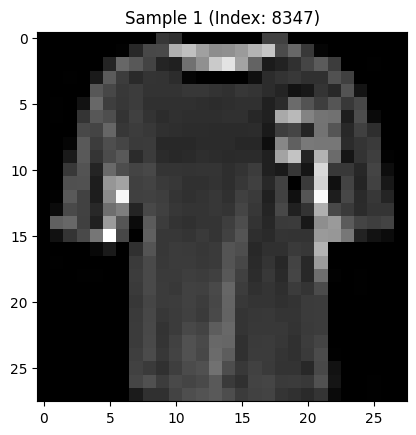

  True Label     : T-shirt/top (0)
  Predicted Label: T-shirt/top (0)
  Match          : O
--------------------


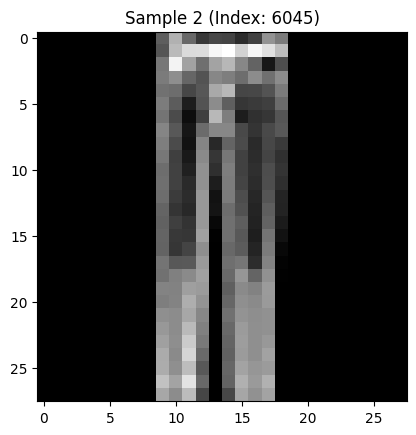

  True Label     : Trouser (1)
  Predicted Label: Trouser (1)
  Match          : O
--------------------


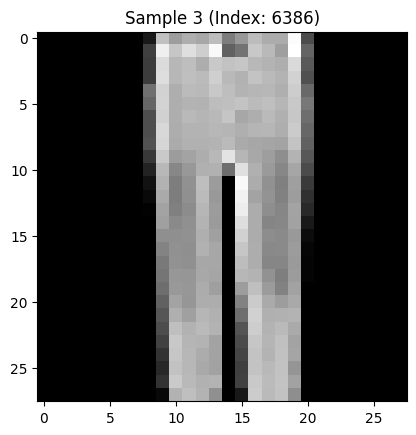

  True Label     : Trouser (1)
  Predicted Label: Trouser (1)
  Match          : O
--------------------


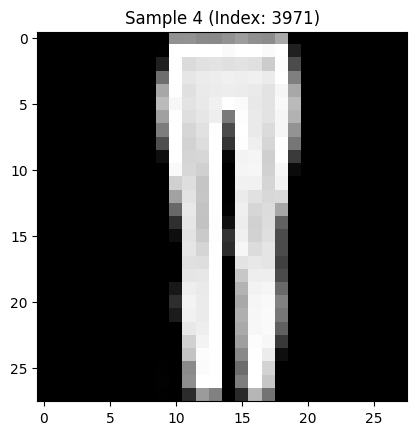

  True Label     : Trouser (1)
  Predicted Label: Trouser (1)
  Match          : O
--------------------


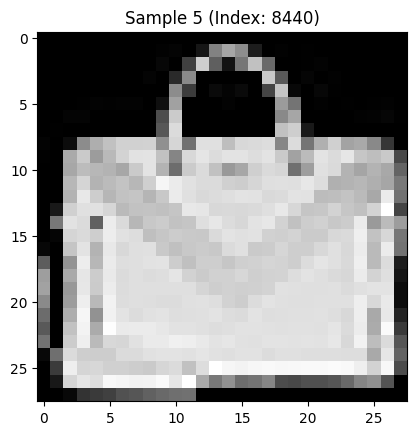

  True Label     : Bag (8)
  Predicted Label: Bag (8)
  Match          : O
--------------------


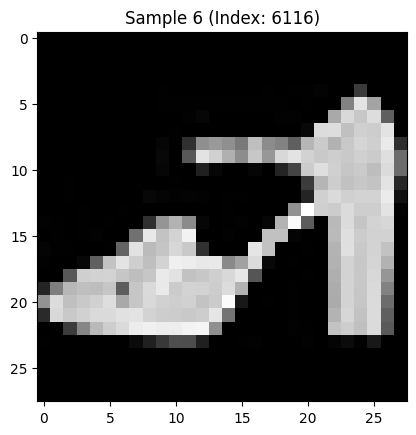

  True Label     : Sandal (5)
  Predicted Label: Sandal (5)
  Match          : O
--------------------


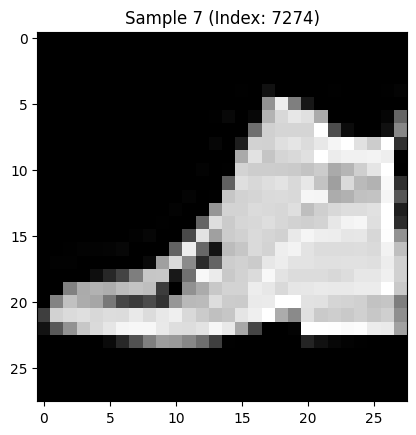

  True Label     : Ankle boot (9)
  Predicted Label: Ankle boot (9)
  Match          : O
--------------------


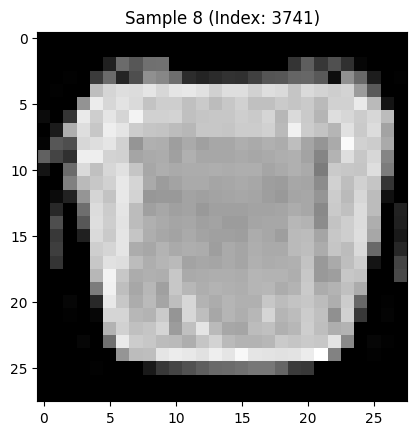

  True Label     : Shirt (6)
  Predicted Label: Bag (8)
  Match          : X
--------------------


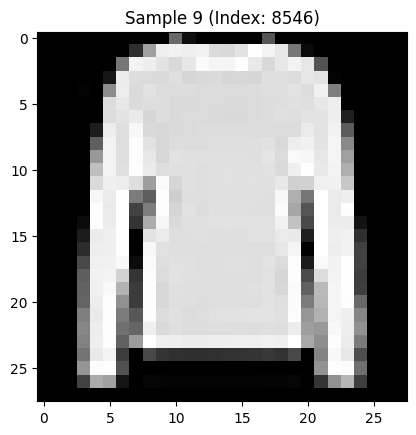

  True Label     : Pullover (2)
  Predicted Label: Pullover (2)
  Match          : O
--------------------


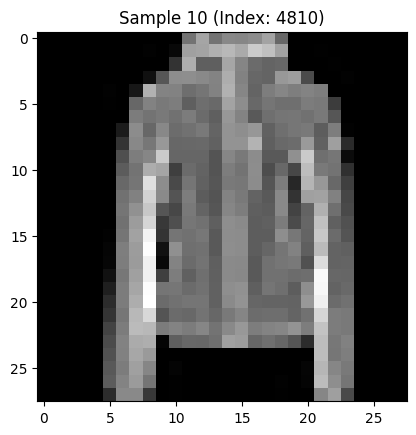

  True Label     : Coat (4)
  Predicted Label: Coat (4)
  Match          : O
--------------------


In [12]:
# Cell 12: 10개 샘플 예측 및 분석 (문제 4)
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

test_images = f_mnist_test_images
model = best_model
model.eval()

print("--- Starting Problem 4: Sample Predictions ---")

# 10개를 '임의로' 뽑되, 그 안에 최소 1개 오답이 포함될 때까지 반복
while True:
    sampled_indices = random.sample(range(len(test_images)), 10)

    results = []      # (idx, image, label, pred, is_match) 저장
    has_incorrect = False

    for idx in sampled_indices:
        image, label = test_images[idx]

        img_tensor = test_transforms(
            transforms.ToTensor()(image)
        ).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor)
            _, pred_idx = torch.max(output, 1)

        predicted_label = pred_idx.item()
        is_match = (predicted_label == label)

        if not is_match:
            has_incorrect = True

        results.append((idx, image, label, predicted_label, is_match))

    # 10개 모두 정답이면 다시 샘플링
    if has_incorrect:
        break
    else:
        print("All 10 samples were correct. Resampling 10 images...")

# 최종 선택된 10개 샘플에 대해 출력
for i, (idx, image, label, predicted_label, is_match) in enumerate(results):
    plt.imshow(image, cmap='gray')
    plt.title(f"Sample {i+1} (Index: {idx})")
    plt.show()

    print(f"  True Label     : {class_names[label]} ({label})")
    print(f"  Predicted Label: {class_names[predicted_label]} ({predicted_label})")
    print(f"  Match          : {'O' if is_match else 'X'}")
    print("-" * 20)


### sample 8이 틀린이유

셔츠의 생김새가 각지고 팔부분이 명확하지 않아 가방으로 분류한 것 같다.

### 최종 하이퍼파라미터 설정

- **Optimizer**
  - AdamW

- **Learning Rate**
  - 초기 학습률: **0.001**

- **Batch Size**
  - **256**

- **Epochs**
  - 최대 **50** epoch 학습
  - `Validation Accuracy`가 가장 높을 때의 모델 가중치만 저장하여 최종 평가에 사용

- **Early Stop / Patience**
  - 명시적인 early stopping은 사용하지 않음
  - 대신 `ReduceLROnPlateau` 스케줄러를 사용하여  
    **Validation Loss가 5 epoch(`patience=5`) 동안 개선되지 않으면**  
    학습률에 0.8(`factor=0.8`)을 곱해 감소시킴  
  - 검증 정확도가 더 이상 크게 개선되지 않을 때 학습률을 줄여  
    과적합을 완화하고 수렴을 안정화하는 역할

- **Weight Decay**
  - **0.00015** (1.5e-4)  
  - AdamW의 decoupled weight decay로 L2 정규화 효과를 부여하여  
    과적합을 방지

- **Normalization Type**
  - **입력 정규화(Input Normalization)**  
    - Fashion-MNIST 학습 데이터 전체에서 **mean / std를 직접 계산**하여  
      `Normalize(mean, std)` 적용
  - **특징 맵 정규화(Feature Normalization)**  
    - 모든 합성곱 층 뒤에 `BatchNorm2d` 사용  
      → 학습 안정화 및 수렴 속도 향상

- **Dropout Rate**
  - Fully-connected 분류기 부분에서 **0.1** 사용  
  - 과적합을 줄이되, 과하게 성능을 깎지 않는 수준으로 설정



## 고찰내용

여러가지 optimzer를 사용해보면서 각각의 optimzer들이 확실히 성능이 다르다는 것을 알수있었다. 그리고 무조건 최신의 기술이 좋다고만은 단정지을수도 없다고 느꼈다. 데이터셋의 크기가 클때와 작을때의 차이가 엄청나다는걸 알수있었다. 55000장의 데이터도 사실 작다고 생각을 안했었는데 딥러닝 모델을 학습시킬때는 굉장히 작은 데이터셋이라서 과적합현상이 자꾸 일어나 데이터 증강 방법을 알아보던중 정적 증강과 동적 증강이라는 것을 알게 되었다. 정적 증강은 단순히 기존 데이터셋을 변환하여 추가로 데이터를 늘리는 방식이고, 동적 증강은 데이터셋의 크기를 증가시키지 않고 학습시킬때 마다 랜덤으로 데이터를 변화를 주어 학습시키는 방법이다. 그리고 가우시안 노이즈라는 방식을 사용했었는데 학습시킬때 이 가우시안 노이즈때문에 오히려 과소적합 현상이 발생했었다. 이번 과제를 통해서 데이터 전처리도 중요하고 모델을 정의하는 것도 중요하고 하이퍼파라미터들을 정하는게 정말 쉬운작업이 아니라고 느꼈다.

## 숙제후기

인터넷을 찾아보면서 fashion-mninst분류 문제가 정말 기초중에 기초인걸 알게되었는데 사실 직전 과제를 해봐서 그런지 이번과제의 시작은 좀 수월했다. 하지만 단순히 성능을 90퍼 혹은 과적합을 방지하는게 아니라 검증데이터의 정확도 94퍼, 테스트데이터의 정확도 93퍼라는 조건을 달성하는게 정말 쉽지 않았다. 수많은 시행착오를 겪으며 간단한 분류모델을 만드는데 이렇게 오래걸리는데 진짜 처음 보는 문제는 어떻게 해야할지 생각이많이 들었다. 앞으로 졸업작품을 만들때 사용을 많이 할거같은데 딥러닝에 대해 좀더 많은 시간을 투자해 공부해야겠다고 생각이 들었다.